# **Fused Decision LSTM-FFNN - feature set 2 dyanmic and static data**

We will combine our Fused Decision LSTM with FFNN to handle both time series and static data.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import torch.nn.utils.parametrizations as param
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import itertools
import json
import pickle

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Handling**

In [ ]:
class MultiInputTimeSeriesDataset(Dataset):
    """
    A custom PyTorch Dataset class for time series data with multiple input sequences.

    Args:
        low_sequences (numpy.ndarray): Low-frequency sequences.
        medium_sequences (numpy.ndarray): Medium-frequency sequences.
        high_sequences (numpy.ndarray): High-frequency sequences.
        labels (numpy.ndarray): Corresponding labels for the sequences.

    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns a dictionary containing the sequences and label for the given index.
    """
    def __init__(self, low_sequences, medium_sequences, high_sequences, static_features, labels):
        self.low_sequences = low_sequences
        self.medium_sequences = medium_sequences
        self.high_sequences = high_sequences
        self.static_features = static_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'low_freq_sequence': torch.tensor(self.low_sequences[idx], dtype=torch.float32),
            'medium_freq_sequence': torch.tensor(self.medium_sequences[idx], dtype=torch.float32),
            'high_freq_sequence': torch.tensor(self.high_sequences[idx], dtype=torch.float32),
            'static': torch.tensor(self.static_features[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

In [ ]:
def create_multi_input_data_loaders(low_freq_train_sequences,
                                    medium_freq_train_sequences,
                                    high_freq_train_sequences,
                                    train_static,
                                    train_labels,
                                    low_freq_val_sequences,
                                    medium_freq_val_sequences,
                                    high_freq_val_sequences,
                                    val_static,
                                    val_labels,
                                    low_freq_test_sequences,
                                    medium_freq_test_sequences,
                                    high_freq_test_sequences,
                                    test_static,
                                    test_labels,
                                    batch_size):
    """
    Create data loaders for multi-input time series data.

    """
    train_dataset = MultiInputTimeSeriesDataset(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, train_labels)
    val_dataset = MultiInputTimeSeriesDataset(low_freq_val_sequences, medium_freq_val_sequences, high_freq_val_sequences, val_static, val_labels)
    test_dataset = MultiInputTimeSeriesDataset(low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, test_static, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

**Data sampling**

In [ ]:
import numpy as np
from sklearn.utils import resample

def undersample_data(low_sequences, medium_sequences, high_sequences, static, labels):
    """
    Undersamples the data by randomly reducing the majority class samples.

    Args:
        low_sequences (np.ndarray): Low frequency sequences.
        medium_sequences (np.ndarray): Medium frequency sequences.
        high_sequences (np.ndarray): High frequency sequences.
        static (np.ndarray): Static features.
        labels (np.ndarray): Corresponding labels for sequences.

    Returns:
        tuple: Undersampled sequences and labels for low, medium, high frequency data, and static data.
    """
    # Identify the minority and majority classes
    minority_class = min(set(labels), key=list(labels).count)
    majority_class = max(set(labels), key=list(labels).count)

    # Split the data into minority and majority classes
    minority_indices = np.where(labels == minority_class)[0]
    majority_indices = np.where(labels == majority_class)[0]

    # Randomly undersample the majority class
    undersampled_majority_indices = resample(majority_indices, replace=False, n_samples=len(minority_indices), random_state=42)

    # Combine minority and undersampled majority indices
    undersampled_indices = np.concatenate([minority_indices, undersampled_majority_indices])

    # Get the undersampled sequences, static, and labels
    low_sequences_resampled = low_sequences[undersampled_indices]
    medium_sequences_resampled = medium_sequences[undersampled_indices]
    high_sequences_resampled = high_sequences[undersampled_indices]
    static_resampled = static[undersampled_indices]
    labels_resampled = labels[undersampled_indices]

    return low_sequences_resampled, medium_sequences_resampled, high_sequences_resampled, static_resampled, labels_resampled

def oversample_data(low_sequences, medium_sequences, high_sequences, static, labels):
    """
    Oversamples the data by duplicating the minority class samples.

    Args:
        low_sequences (np.ndarray): Low frequency sequences.
        medium_sequences (np.ndarray): Medium frequency sequences.
        high_sequences (np.ndarray): High frequency sequences.
        static (np.ndarray): Static features.
        labels (np.ndarray): Corresponding labels for sequences.

    Returns:
        tuple: Oversampled sequences and labels for low, medium, high frequency data, and static data.
    """
    # Identify the minority and majority classes
    minority_class = min(set(labels), key=list(labels).count)
    majority_class = max(set(labels), key=list(labels).count)

    # Split the data into minority and majority classes
    minority_indices = np.where(labels == minority_class)[0]
    majority_indices = np.where(labels == majority_class)[0]

    # Randomly oversample the minority class
    oversampled_minority_indices = resample(minority_indices, replace=True, n_samples=len(majority_indices), random_state=42)

    # Combine majority and oversampled minority indices
    oversampled_indices = np.concatenate([majority_indices, oversampled_minority_indices])

    # Get the oversampled sequences, static, and labels
    low_sequences_resampled = low_sequences[oversampled_indices]
    medium_sequences_resampled = medium_sequences[oversampled_indices]
    high_sequences_resampled = high_sequences[oversampled_indices]
    static_resampled = static[oversampled_indices]
    labels_resampled = labels[oversampled_indices]

    return low_sequences_resampled, medium_sequences_resampled, high_sequences_resampled, static_resampled, labels_resampled

**Early Stopping**

In [ ]:
class EarlyStopping:
    def __init__(self, output_path, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.output_path = output_path

    def __call__(self, val_auc, model):
        if self.best_score is None:
            self.best_score = val_auc
            self.save_checkpoint(model)
        elif val_auc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_auc
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.output_path)

### **Fused Decision LSTM-FFNN architecture**

We will combine the Fused LSTM model with FFNN to handle both static and dynamic data.

In [ ]:
class FusedLSTM_FFNN(nn.Module):
    """
    A fused LSTM model for sequence classification and handles masking.

    """
    def __init__(self, low_input_dim, medium_input_dim, high_input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, static_input_size, ffnn_layers, ffnn_units, ffnn_activation, ffnn_dropout):
      super(FusedLSTM_FFNN, self).__init__()
      self.hidden_dim = hidden_dim
      self.layer_dim = layer_dim

      if layer_dim == 1:
        dropout_prob = 0.0

      # LSTM for dynamic data
      self.low_lstm = nn.LSTM(low_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
      self.medium_lstm = nn.LSTM(medium_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
      self.high_lstm = nn.LSTM(high_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)


      # FFNN for static data
      ffnn_layers_list = []
      input_dim = static_input_size
      for _ in range(ffnn_layers):
        ffnn_layers_list.append(nn.Linear(input_dim, ffnn_units)) # Add linear layer
        if ffnn_activation == 'relu':
          ffnn_layers_list.append(nn.ReLU()) # Add ReLU activation function
        elif ffnn_activation == 'tanh':
          ffnn_layers_list.append(nn.Tanh()) # Add Tanh activation function
        elif ffnn_activation == 'sigmoid':
          ffnn_layers_list.append(nn.Sigmoid()) # Add Sigmoid activation function
        elif ffnn_activation == 'leaky_relu':
          ffnn_layers_list.append(nn.LeakyReLU()) # Add LeakyReLU activation function
        ffnn_layers_list.append(nn.Dropout(ffnn_dropout)) # Add dropout layer
        input_dim = ffnn_units # Update input dimension for next layer

      self.ffnn_network = nn.Sequential(*ffnn_layers_list)
      self.ffnn_output = nn.Linear(ffnn_units, hidden_dim)

      # Combined output
      self.combined_linear = nn.Linear(hidden_dim * 4, output_dim)

      # Define sigmoid for binary classification
      self.sigmoid = nn.Sigmoid()

      self.init_weights()

    # Function to initialize weights of the linear layer
    def init_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Linear):
              nn.init.kaiming_normal_(m.weight)
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)

    # Forward pass
    def forward(self, low_x, medium_x, high_x, static):
      # Create masks and handle NaNs
      low_mask = ~low_x.isnan()
      medium_mask = ~medium_x.isnan()
      high_mask = ~high_x.isnan()

      # Set NaNs to zeroes to be passed through model
      low_x = torch.where(low_mask, low_x, torch.zeros_like(low_x))
      medium_x = torch.where(medium_mask, medium_x, torch.zeros_like(medium_x))
      high_x = torch.where(high_mask, high_x, torch.zeros_like(high_x))

      # Initial hidden and cell states
      h0_low = torch.zeros(self.layer_dim, low_x.size(0), self.hidden_dim).to(low_x.device)
      c0_low = torch.zeros(self.layer_dim, low_x.size(0), self.hidden_dim).to(low_x.device)

      h0_medium = torch.zeros(self.layer_dim, medium_x.size(0), self.hidden_dim).to(medium_x.device)
      c0_medium = torch.zeros(self.layer_dim, medium_x.size(0), self.hidden_dim).to(medium_x.device)

      h0_high = torch.zeros(self.layer_dim, high_x.size(0), self.hidden_dim).to(high_x.device)
      c0_high = torch.zeros(self.layer_dim, high_x.size(0), self.hidden_dim).to(high_x.device)

      # Forward pass through LSTM layers
      low_out, _ = self.low_lstm(low_x, (h0_low, c0_low))
      medium_out, _ = self.medium_lstm(medium_x, (h0_medium, c0_medium))
      high_out, _ = self.high_lstm(high_x, (h0_high, c0_high))

      # Ensure masks are the same shape as the LSTM outputs
      low_mask = low_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, low_out.shape[-1])
      medium_mask = medium_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, medium_out.shape[-1])
      high_mask = high_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, high_out.shape[-1])

      # Apply masks to the LSTM outputs by zeroing out invalid positions
      low_out = low_out * low_mask.float()
      medium_out = medium_out * medium_mask.float()
      high_out = high_out * high_mask.float()

      # Get the last valid output for each sequence
      def get_last_valid_output(output, mask):
        last_valid_index = mask.sum(dim=1) - 1
        last_valid_index = torch.clamp(last_valid_index, min=0)  # Ensure no negative indices
        last_valid_index = last_valid_index.unsqueeze(1).unsqueeze(2).expand(-1, 1, output.size(-1))
        return output.gather(1, last_valid_index).squeeze(1)

      low_out_last = get_last_valid_output(low_out, low_mask[:, :, 0])
      medium_out_last = get_last_valid_output(medium_out, medium_mask[:, :, 0])
      high_out_last = get_last_valid_output(high_out, high_mask[:, :, 0])

      # Concatenate the LSTM outputs
      dynamic_out = torch.cat((low_out_last, medium_out_last, high_out_last), dim=1)

      # FFNN forward pass
      static_out = self.ffnn_network(static)
      static_out = self.ffnn_output(static_out)

      # Combine dynamic and static outputs
      out = torch.cat((dynamic_out, static_out), dim=1)

      # Apply the fully connected layer to fuse outputs
      out = self.combined_linear(out)

      # Apply sigmoid for binary classification
      out = self.sigmoid(out)

      return out

**Model training**

In [ ]:
def train_fused_model_with_early_stopping_logging(model, train_loader, val_loader,
                                                  criterion, optimizer, num_epochs, device, patience, output_path):
    """
    Train the fused LSTM model with early stopping and logging.

    Parameters:
    model (nn.Module): The fused LSTM model to be trained.
    train_loader (DataLoader): DataLoader for the training data.
    val_loader (DataLoader): DataLoader for the validation data.
    criterion (nn.Module): Loss function.
    optimizer (torch.optim.Optimizer): Optimizer.
    num_epochs (int): Number of epochs to train the model.
    device (torch.device): Device to run the model on (CPU or GPU).
    patience (int): Number of epochs to wait for improvement before stopping early.
    output_path (str): Path to save the best model checkpoint.

    Returns:
    model (nn.Module): The trained LSTM model.
    train_losses (list): List of training losses per epoch.
    val_losses (list): List of validation losses per epoch.
    val_aucs (list): List of validation AUC scores per epoch.
    """
    model.to(device)
    best_model_wts = model.state_dict()
    best_auc = 0.0

    early_stopping = EarlyStopping(output_path, patience=patience, min_delta=0)

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            running_loss += loss.item() * low_freq_sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_running_loss = 0.0
        val_outputs = []
        val_labels = []

        with torch.no_grad():
            for data in val_loader:
                low_freq_sequences = data['low_freq_sequence'].to(device)
                medium_freq_sequences = data['medium_freq_sequence'].to(device)
                high_freq_sequences = data['high_freq_sequence'].to(device)
                static = data['static'].to(device)
                labels = data['label'].to(device).view(-1, 1)

                outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static)

                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * low_freq_sequences.size(0)

                val_outputs.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        val_auc = roc_auc_score(val_labels, val_outputs)
        val_aucs.append(val_auc)

        early_stopping(val_auc, model)

        if val_auc > best_auc:
            best_auc = val_auc
            best_model_wts = model.state_dict()

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_aucs

**Cross-validation**

In [ ]:
import numpy as np

def shuffle_data(low_sequences, medium_sequences, high_sequences, static_data, labels):
    assert len(low_sequences) == len(medium_sequences) == len(high_sequences) == len(static_data) == len(labels)
    p = np.random.permutation(len(labels))
    return low_sequences[p], medium_sequences[p], high_sequences[p], static_data[p], labels[p]

def split_data_into_folds(low_sequences, medium_sequences, high_sequences, static_data, labels, num_folds):
    fold_size = len(labels) // num_folds
    low_folds = []
    medium_folds = []
    high_folds = []
    static_folds = []
    labels_folds = []
    for i in range(num_folds):
        start_idx = i * fold_size
        if i == num_folds - 1:  # Make sure the last fold includes any remaining data points
            end_idx = len(labels)
        else:
            end_idx = start_idx + fold_size
        low_folds.append(low_sequences[start_idx:end_idx])
        medium_folds.append(medium_sequences[start_idx:end_idx])
        high_folds.append(high_sequences[start_idx:end_idx])
        static_folds.append(static_data[start_idx:end_idx])
        labels_folds.append(labels[start_idx:end_idx])
    return low_folds, medium_folds, high_folds, static_folds, labels_folds

In [ ]:
import torch.nn as nn

def reset_model(model):
    """
    Reset the parameters of the model to their initial values.

    Parameters:
    model (nn.Module): The model whose parameters need to be reset.
    """
    def reset_parameters(layer):
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    def reset_lstm_parameters(lstm_model):
        for name, param in lstm_model.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_normal_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)

    # Reset parameters for the main model
    reset_parameters(model)

    # Reset parameters for each LSTM in the FusedLSTMModel
    reset_lstm_parameters(model.low_lstm)
    reset_lstm_parameters(model.medium_lstm)
    reset_lstm_parameters(model.high_lstm)

    # Reset parameters for the FFNN layers
    for layer in model.ffnn_network.children():
        reset_parameters(layer)

    # Reset parameters for fully connected and sigmoid layers
    reset_parameters(model.ffnn_output)
    reset_parameters(model.combined_linear)
    reset_parameters(model.sigmoid)

In [ ]:
def fused_lstm_ffnn_manual_cross_validation(low_sequences, medium_sequences, high_sequences,
                                            static_data, labels, hyperparameters, num_folds=5, patience=5, output_path=None):
    low_sequences, medium_sequences, high_sequences, static_data, labels = shuffle_data(low_sequences, medium_sequences, high_sequences, static_data, labels)
    low_folds, medium_folds, high_folds, static_folds, labels_folds = split_data_into_folds(low_sequences, medium_sequences, high_sequences, static_data, labels, num_folds)

    best_auc = 0.0
    best_model = None
    best_hyperparams = None

    best_train_losses = None
    best_val_losses = None
    best_val_aucs = None

    for i in range(num_folds):
        val_low = low_folds[i]
        val_medium = medium_folds[i]
        val_high = high_folds[i]
        val_static = static_folds[i]
        val_labels = labels_folds[i]

        train_low = np.concatenate([low_folds[j] for j in range(num_folds) if j != i])
        train_medium = np.concatenate([medium_folds[j] for j in range(num_folds) if j != i])
        train_high = np.concatenate([high_folds[j] for j in range(num_folds) if j != i])
        train_static = np.concatenate([static_folds[j] for j in range(num_folds) if j != i])
        train_labels = np.concatenate([labels_folds[j] for j in range(num_folds) if j != i])

        low_input_dim = train_low.shape[2]
        medium_input_dim = train_medium.shape[2]
        high_input_dim = train_high.shape[2]
        static_input_size = train_static.shape[1]

        for params in hyperparameters:
            if params['sampling_method'] == 'undersample':
                train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = undersample_data(
                    train_low, train_medium, train_high, train_static, train_labels)
            elif params['sampling_method'] == 'oversample':
                train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = oversample_data(
                    train_low, train_medium, train_high, train_static, train_labels)
            else:
                train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = train_low, train_medium, train_high, train_static, train_labels

            train_loader, val_loader, _ = create_multi_input_data_loaders(
                train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled,
                val_low, val_medium, val_high, val_static, val_labels,
                val_low, val_medium, val_high, val_static, val_labels,
                batch_size=params['batch_size']
            )

            # Model with new hyperparameters
            model = FusedLSTM_FFNN(
                low_input_dim=low_input_dim,
                medium_input_dim=medium_input_dim,
                high_input_dim=high_input_dim,
                hidden_dim=params['hidden_dim'],
                layer_dim=params['layer_dim'],
                output_dim=1,  # Binary classification
                dropout_prob=params['dropout_prob'],
                static_input_size=static_input_size,
                ffnn_layers=params['ffnn_layers'],
                ffnn_units=params['ffnn_units'],
                ffnn_activation=params['ffnn_activation'],
                ffnn_dropout=params['ffnn_dropout']
            ).to(device)

            reset_model(model)

            criterion = nn.BCELoss()

            if params['loss'] == 'weighted' and params['sampling_method'] == 'normal':
                pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

            optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

            model, train_losses, val_losses, val_aucs = train_fused_model_with_early_stopping_logging(
                model, train_loader, val_loader, criterion, optimizer,
                params['num_epochs'], device, patience, output_path
            )

            val_outputs = []
            val_labels_list = []
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    low_freq_sequences = data['low_freq_sequence'].to(device)
                    medium_freq_sequences = data['medium_freq_sequence'].to(device)
                    high_freq_sequences = data['high_freq_sequence'].to(device)
                    static = data['static'].to(device)
                    labels = data['label'].to(device).view(-1, 1)
                    outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static)
                    val_outputs.extend(outputs.cpu().numpy().flatten())
                    val_labels_list.extend(labels.cpu().numpy().flatten())

            val_auc = roc_auc_score(val_labels_list, val_outputs)
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model
                best_hyperparams = params
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_val_aucs = val_aucs

            print(f"Params: {params}, Val AUC: {val_auc:.4f}")

    if best_train_losses and best_val_losses and best_val_aucs:
        epochs = range(1, len(best_train_losses) + 1)
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, best_train_losses, 'b-', label='Training loss')
        plt.plot(epochs, best_val_losses, 'r-', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, best_val_aucs, 'g-', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return best_model, best_hyperparams, best_auc, best_train_losses, best_val_losses, best_val_aucs


**Bayesian Objective Function**

In [ ]:
def objective_wrapper(low_train_sequences, medium_train_sequences, high_train_sequences, static_train_data, train_labels, hyperparameter_grid):
    def objective(trial):
        hidden_dim = trial.suggest_categorical('hidden_dim', hyperparameter_grid['hidden_dim'])
        layer_dim = trial.suggest_categorical('layer_dim', hyperparameter_grid['layer_dim'])
        dropout_prob = trial.suggest_categorical('dropout_prob', hyperparameter_grid['dropout_prob'])
        learning_rate = trial.suggest_categorical('learning_rate', hyperparameter_grid['learning_rate'])
        batch_size = trial.suggest_categorical('batch_size', hyperparameter_grid['batch_size'])
        num_epochs = trial.suggest_int('num_epochs', min(hyperparameter_grid['num_epochs']), max(hyperparameter_grid['num_epochs']), step=10)
        sampling_method = trial.suggest_categorical('sampling_method', hyperparameter_grid['sampling_method'])
        loss = trial.suggest_categorical('loss', hyperparameter_grid['loss'])
        weight_decay = trial.suggest_categorical('weight_decay', hyperparameter_grid['weight_decay'])

        # FFNN specific hyperparameters
        ffnn_layers = trial.suggest_int('ffnn_layers', min(hyperparameter_grid['ffnn_layers']), max(hyperparameter_grid['ffnn_layers']))
        ffnn_units = trial.suggest_categorical('ffnn_units', hyperparameter_grid['ffnn_units'])
        ffnn_activation = trial.suggest_categorical('ffnn_activation', hyperparameter_grid['ffnn_activation'])
        ffnn_dropout = trial.suggest_categorical('ffnn_dropout', hyperparameter_grid['ffnn_dropout'])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
            raise optuna.TrialPruned()

        hyperparameters = {
            'hidden_dim': hidden_dim,
            'layer_dim': layer_dim,
            'dropout_prob': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay,
            'ffnn_layers': ffnn_layers,
            'ffnn_units': ffnn_units,
            'ffnn_activation': ffnn_activation,
            'ffnn_dropout': ffnn_dropout,
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc, best_train_losses, best_val_losses, best_val_aucs = fused_lstm_ffnn_manual_cross_validation(
            low_train_sequences,
            medium_train_sequences,
            high_train_sequences,
            static_train_data,
            train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

**Train final model**

In [ ]:
def train_final_model(model, train_loader, criterion, optimizer, num_epochs, device):
    """
    Train the model with the given parameters.

    Parameters:
    model (nn.Module): The neural network model to be trained.
    train_loader (DataLoader): The DataLoader for the training dataset.
    criterion (nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    num_epochs (int): The number of epochs to train the model.
    device (torch.device): The device to train the model on.

    Returns:
    nn.Module: The trained model.
    list: The list of training losses over epochs.
    """
    model.to(device)
    model.train()

    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in train_loader:
            # Get the input sequences and labels
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)  # Static data input
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * low_freq_sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Plot the training losses at the end of training
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

    return model, train_losses

**Evaluate model**

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test dataset and calculate various evaluation metrics.

    Parameters:
    model (nn.Module): The trained model to evaluate.
    test_loader (DataLoader): The DataLoader for the test dataset.
    device (torch.device): The device to run the model on.

    Returns:
    tuple: A tuple containing accuracy, precision, recall, F1 score, ROC AUC, and specificity.
    """
    model.to(device)
    model.eval()
    test_outputs = []
    test_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)  # Static data input
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)
            test_outputs.extend(outputs.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy().flatten())

    test_outputs = np.array(test_outputs)
    test_labels = np.array(test_labels)

    # Calculate various metrics
    accuracy = accuracy_score(test_labels, test_outputs.round())
    precision = precision_score(test_labels, test_outputs.round())
    recall = recall_score(test_labels, test_outputs.round())
    f1 = f1_score(test_labels, test_outputs.round())
    roc_auc = roc_auc_score(test_labels, test_outputs)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_outputs.round()).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return (accuracy, precision, recall, f1, roc_auc, specificity), test_outputs

**Load the data**

In [ ]:
# Load the sequences and labels
low_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/low_frequency_train_sequences_v1.npy'
medium_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/medium_frequency_train_sequences_v1.npy'
high_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/high_frequency_train_sequences_v1.npy'
labels_train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/low_frequency_train_labels_v1.npy'

low_freq_train_sequences = np.load(low_train_seq_path, allow_pickle=True).astype(np.float32)
medium_freq_train_sequences = np.load(medium_train_seq_path, allow_pickle=True).astype(np.float32)
high_freq_train_sequences = np.load(high_train_seq_path, allow_pickle=True).astype(np.float32)
labels_train = np.load(labels_train_path, allow_pickle=True).astype(np.float32)

print("Low frequency sequences shape:", low_freq_train_sequences.shape)
print("Medium frequency sequences shape:", medium_freq_train_sequences.shape)
print("High frequency sequences shape:", high_freq_train_sequences.shape)
print("Labels shape:", labels_train.shape)

Low frequency sequences shape: (3760, 4, 3)
Medium frequency sequences shape: (3760, 7, 10)
High frequency sequences shape: (3760, 13, 6)
Labels shape: (3760,)


In [ ]:
# Load the test sequences
low_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/low_frequency_test_sequences_v1.npy'
medium_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/medium_frequency_test_sequences_v1.npy'
high_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/high_frequency_test_sequences_v1.npy'

# Load the test labels
test_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/low_frequency_test_labels_v1.npy'

low_freq_test_sequences = np.load(low_test_seq_path, allow_pickle=True).astype(np.float32)
medium_freq_test_sequences = np.load(medium_test_seq_path, allow_pickle=True).astype(np.float32)
high_freq_test_sequences = np.load(high_test_seq_path, allow_pickle=True).astype(np.float32)

labels_test = np.load(test_labels_path, allow_pickle=True).astype(np.float32)

print(f'Low frequency test sequences shape: {low_freq_test_sequences.shape}')
print(f'Medium frequency test sequences shape: {medium_freq_test_sequences.shape}')
print(f'High frequency test sequences shape: {high_freq_test_sequences.shape}')
print(f'Test labels shape: {labels_test.shape}')

Low frequency test sequences shape: (941, 4, 3)
Medium frequency test sequences shape: (941, 7, 10)
High frequency test sequences shape: (941, 13, 6)
Test labels shape: (941,)


In [ ]:
# Load the static data
train_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/static_data/train_static.npy'
test_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/static_data/test_static.npy'

# Load the static data
train_static = np.load(train_static_path, allow_pickle=True).astype(np.float32)
test_static = np.load(test_static_path, allow_pickle=True).astype(np.float32)

print(f'Train static shape: {train_static.shape}')
print(f'Test static shape: {test_static.shape}')

Train static shape: (3760, 15)
Test static shape: (941, 15)


In [ ]:
train_static

array([[1.00018840e+07, 3.07330817e-01, 2.50000000e-01, ...,
        0.00000000e+00, 0.00000000e+00, 6.45161280e-03],
       [1.00024280e+07, 1.00563906e-01, 1.04166664e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.29032256e-02],
       [1.00042350e+07, 8.90037596e-01, 7.91666687e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.79203500e+07, 3.93796980e-01, 4.79166657e-01, ...,
        0.00000000e+00, 0.00000000e+00, 3.22580640e-03],
       [1.79217000e+07, 7.88533807e-01, 1.45833328e-01, ...,
        0.00000000e+00, 0.00000000e+00, 3.22580640e-03],
       [1.79231460e+07, 4.58616436e-01, 4.16666657e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], dtype=float32)

In [ ]:
# Remove the first column data
train_static = train_static[:, 1:]
test_static = test_static[:, 1:]

train_static

array([[0.30733082, 0.25      , 0.33753806, ..., 0.        , 0.        ,
        0.00645161],
       [0.10056391, 0.10416666, 0.17538421, ..., 0.        , 0.        ,
        0.01290323],
       [0.8900376 , 0.7916667 , 0.59560055, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.39379698, 0.47916666, 0.3357386 , ..., 0.        , 0.        ,
        0.00322581],
       [0.7885338 , 0.14583333, 0.8719525 , ..., 0.        , 0.        ,
        0.00322581],
       [0.45861644, 0.41666666, 0.41387522, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
train_static.shape, test_static.shape

((3760, 14), (941, 14))

# **Experiment 1**

Hyperparameters are a mix between the original LSTM params and FFNN params

In [ ]:
# Define new hyperparameter grid
param_grid_exp_1 = {
    'hidden_dim': [32, 64, 128, 256, 512],
    'layer_dim': [1, 2, 3, 4], # In line with Zeng et al.
    'dropout_prob': [0.0, 0.25, 0.5, 0.75], # To mimic LSTM
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],  # Learning rates to explore
    'batch_size': [16, 32, 64, 128, 256],
    'num_epochs': list(range(10, 101, 10)),  # Epochs from 10 to 100
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [1e-5, 1e-4, 1e-3, 1e-2],
    'ffnn_layers': [1, 2, 3],
    'ffnn_units': [32, 64, 128, 256],
    'ffnn_activation': ['relu', 'tanh', 'sigmoid', 'leaky_relu'],
    'ffnn_dropout': [0.0, 0.25, 0.5, 0.75] # To mimic LSTM range
}

Run Bayesian Optimisation for Hyperparameter tuning

In [ ]:
# Run Bayesian Optimisation
study_exp_1 = optuna.create_study(direction='minimize')
study_exp_1.optimize(objective_wrapper(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, labels_train, param_grid_exp_1), n_trials=100)

best_params = study_exp_1.best_params
print("Best hyperparameters:", best_params)

# Save the best params
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/02_feature_set_2/01_lstm_fused_decision/static_and_dynamic/best_models/experiment_1/best_params.json'
with open(params_path, 'w') as f:
    json.dump(best_params, f)

best_score = study_exp_1.best_value
print("Best score:", best_score)

Output hidden; open in https://colab.research.google.com to view.

Best hyperparameters: {'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.0, 'learning_rate': 0.001, 'batch_size': 256, 'num_epochs': 50, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 1e-05, 'ffnn_layers': 1, 'ffnn_units': 32, 'ffnn_activation': 'tanh', 'ffnn_dropout': 0.75}

Best score: -0.6931895618711669

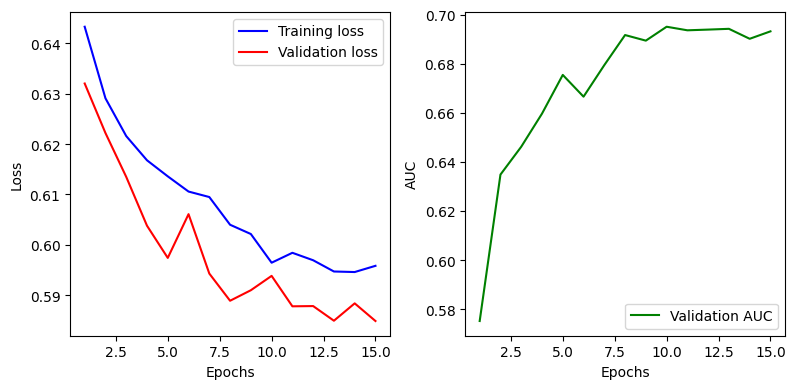

In [ ]:
best_params = {'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.0, 'learning_rate': 0.001, 'batch_size': 256, 'num_epochs': 50, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 1e-05, 'ffnn_layers': 1, 'ffnn_units': 32, 'ffnn_activation': 'tanh', 'ffnn_dropout': 0.75}

**Train the final model**

In [ ]:
best_params

{'hidden_dim': 64,
 'layer_dim': 2,
 'dropout_prob': 0.0,
 'learning_rate': 0.001,
 'batch_size': 256,
 'num_epochs': 50,
 'sampling_method': 'normal',
 'loss': 'normal',
 'weight_decay': 1e-05,
 'ffnn_layers': 1,
 'ffnn_units': 32,
 'ffnn_activation': 'tanh',
 'ffnn_dropout': 0.75}

In [ ]:
# Define the final model
final_model = FusedLSTM_FFNN(
    low_input_dim=low_freq_train_sequences.shape[2],
    medium_input_dim=medium_freq_train_sequences.shape[2],
    high_input_dim=high_freq_train_sequences.shape[2],
    hidden_dim=best_params['hidden_dim'],
    layer_dim=best_params['layer_dim'],
    output_dim=1,
    dropout_prob=best_params['dropout_prob'],
    static_input_size=train_static.shape[1],
    ffnn_layers=best_params['ffnn_layers'],
    ffnn_units=best_params['ffnn_units'],
    ffnn_activation=best_params['ffnn_activation'],
    ffnn_dropout=best_params['ffnn_dropout']
)

final_model

FusedLSTM_FFNN(
  (low_lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (medium_lstm): LSTM(10, 64, num_layers=2, batch_first=True)
  (high_lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (ffnn_network): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.75, inplace=False)
  )
  (ffnn_output): Linear(in_features=32, out_features=64, bias=True)
  (combined_linear): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Handle sampling methods
if best_params['sampling_method'] == 'undersample':
      train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = undersample_data(
          low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, labels_train)
elif best_params['sampling_method'] == 'oversample':
      train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = oversample_data(
          low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, labels_train)
else:
      train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, labels_train

# Define the loss function
if best_params['loss'] == 'weighted':
  pos_weight = torch.tensor([best_params['pos_weight']]).to(device)
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
  criterion = nn.BCELoss()

# Define the optimiser
optimizer = optim.Adam(
    final_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
final_model.to(device)

# Create data loaders
train_loader, _, test_loader = create_multi_input_data_loaders(
  train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled,
  _, _, _, _, _,
  low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, test_static, labels_test,
  batch_size=best_params['batch_size']
)

Epoch 1/50, Loss: 0.6683
Epoch 2/50, Loss: 0.6391
Epoch 3/50, Loss: 0.6354
Epoch 4/50, Loss: 0.6233
Epoch 5/50, Loss: 0.6184
Epoch 6/50, Loss: 0.6179
Epoch 7/50, Loss: 0.6126
Epoch 8/50, Loss: 0.6104
Epoch 9/50, Loss: 0.6147
Epoch 10/50, Loss: 0.6127
Epoch 11/50, Loss: 0.6085
Epoch 12/50, Loss: 0.6062
Epoch 13/50, Loss: 0.6081
Epoch 14/50, Loss: 0.6038
Epoch 15/50, Loss: 0.6069
Epoch 16/50, Loss: 0.6023
Epoch 17/50, Loss: 0.6026
Epoch 18/50, Loss: 0.6004
Epoch 19/50, Loss: 0.5991
Epoch 20/50, Loss: 0.6013
Epoch 21/50, Loss: 0.6014
Epoch 22/50, Loss: 0.5983
Epoch 23/50, Loss: 0.6010
Epoch 24/50, Loss: 0.5988
Epoch 25/50, Loss: 0.5997
Epoch 26/50, Loss: 0.5979
Epoch 27/50, Loss: 0.5968
Epoch 28/50, Loss: 0.5957
Epoch 29/50, Loss: 0.5944
Epoch 30/50, Loss: 0.5956
Epoch 31/50, Loss: 0.5960
Epoch 32/50, Loss: 0.5986
Epoch 33/50, Loss: 0.5955
Epoch 34/50, Loss: 0.5956
Epoch 35/50, Loss: 0.5967
Epoch 36/50, Loss: 0.5957
Epoch 37/50, Loss: 0.5977
Epoch 38/50, Loss: 0.5991
Epoch 39/50, Loss: 0.

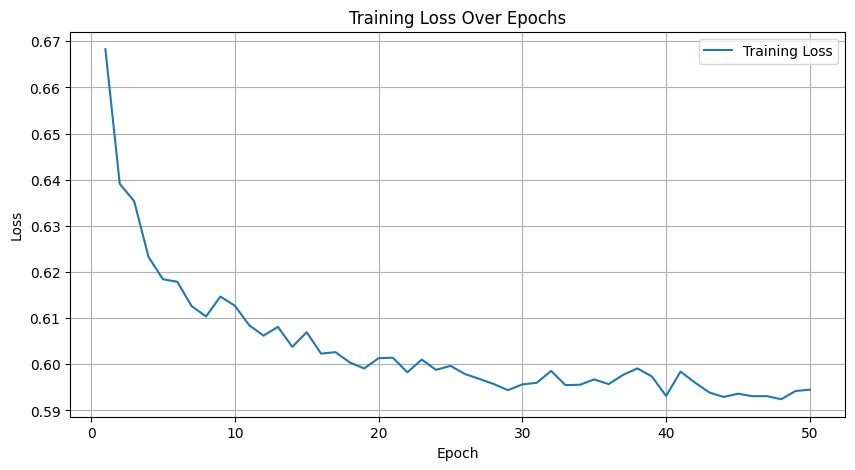

In [ ]:
# Train the final model
final_model, train_losses = train_final_model(
    final_model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=best_params['num_epochs'],
    device=device
)

In [ ]:
import pickle

In [ ]:
# Save the model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/02_feature_set_2/01_lstm_fused_decision/static_and_dynamic/best_models/experiment_1/final_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)


**Evaluate the final model**

In [ ]:
# Evaluate the final model
evaluate_model(final_model, test_loader, device)

Accuracy: 0.6982
Precision: 0.6106
Recall (Sensitivity): 0.2233
F1 Score: 0.3270
ROC AUC: 0.6696
Specificity: 0.9304


(0.6981934112646121,
 0.6106194690265486,
 0.22330097087378642,
 0.32701421800947866,
 0.6695700708696899,
 0.930379746835443)

In [ ]:
# Load the best model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/02_feature_set_2/01_lstm_fused_decision/static_and_dynamic/best_models/experiment_1/final_model.pkl'
with open(model_path, 'rb') as f:
    final_model = pickle.load(f)

In [ ]:
_, predictions = evaluate_model(final_model, test_loader, device)

Accuracy: 0.6982
Precision: 0.6106
Recall (Sensitivity): 0.2233
F1 Score: 0.3270
ROC AUC: 0.6696
Specificity: 0.9304


In [ ]:
# Save predictions for ensemble method
np.save('/content/drive/MyDrive/MSc_Final_Project/03_model_development/02_feature_set_2/01_lstm_fused_decision/static_and_dynamic/best_models/experiment_1/predictions.npy', predictions)

**Calculate F1 mintority**

In [ ]:
def calculate_f1_minority(model, test_loader, device):
    """
    Calculate the F1 score for the minority class.

    Parameters:
    model (nn.Module): Trained LSTM model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    float: F1 score for the minority class.
    """
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)
            labels = data['label'].to(device)

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)
            predictions = (outputs >= 0.5).cpu().numpy().astype(int)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions)

    # Calculate F1 score for the minority class (class 1)
    f1_minority = f1_score(all_labels, all_predictions, average='binary', pos_label=1)
    return f1_minority

In [ ]:
calculate_f1_minority(final_model, test_loader, device)

0.32701421800947866

**Confusion matrix**

In [ ]:
def get_model_predictions(model, test_loader, device):
    """
    Get model predictions and true labels from the test data.

    Parameters:
    model (nn.Module): Trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    tuple: A tuple containing true labels, predicted labels, and output scores.
    """
    model.to(device)
    model.eval()

    # Ensure the LSTM weights are compacted
    if hasattr(model, 'lstm'):
        model.lstm.flatten_parameters()

    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_test_sequences = data['low_freq_sequence'].to(device)
            medium_freq_test_sequences = data['medium_freq_sequence'].to(device)
            high_freq_test_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, static_data)

            preds = (outputs >= 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_scores)

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Plot the confusion matrix using seaborn heatmap.

    Parameters:
    cm (array-like): Confusion matrix.
    class_names (list): List of class names.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names
class_names = ['extubation_success', 'extubation_failure']  # Replace with your actual class names if different

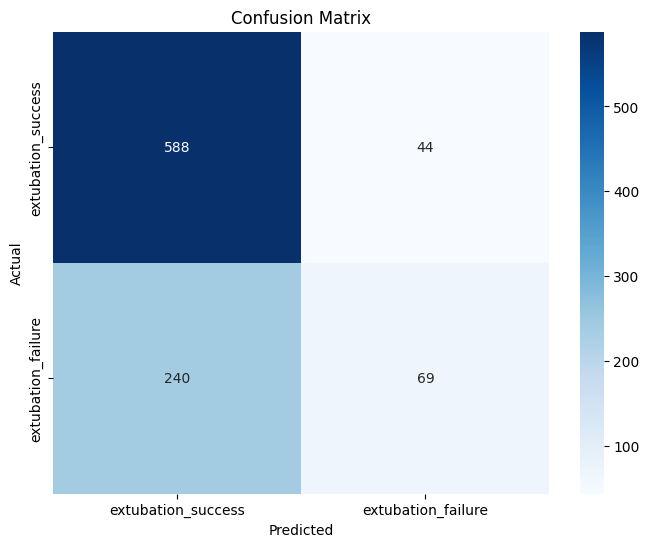

In [ ]:
y_true, y_pred, y_scores = get_model_predictions(final_model, test_loader, device)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)

Heavily weighted on the extubation success side which is similar to TCN-FFNN.

**Plot ROC curve**

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import roc_curve

def plot_roc_curve(model, test_loader, device):
    """
    Generates and plots the ROC curve for the given model and test data.

    Parameters:
    model (torch.nn.Module): The trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): The device to run the model on (CPU or GPU).

    Returns:
    None
    """
    model.to(device)
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            # Get model output (predicted probabilities)
            output = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc_score(all_labels, all_probs)))
    plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

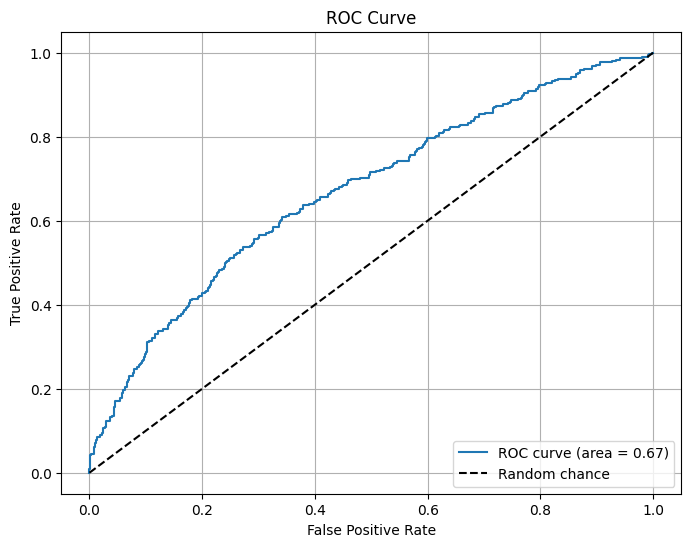

In [ ]:
plot_roc_curve(final_model, test_loader, device)

**Classification Threshold**

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def find_best_threshold_and_evaluate(model, test_loader, device):
    """
    Find the best threshold for binary classification based on ROC AUC and calculate evaluation metrics.

    Parameters:
    model (nn.Module): The trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    dict: A dictionary containing the best threshold, ROC AUC, and other evaluation metrics.
    """
    model.eval()  # Set the model to evaluation mode

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            # Get model output (predicted probabilities)
            output = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    best_threshold = 0.5
    best_metric_value = 0.0

    thresholds = np.arange(0.0, 1.0, 0.01)  # You can change the step size if needed

    for threshold in thresholds:
        preds = (all_probs >= threshold).astype(int)
        metric_value = f1_score(all_labels, preds)

        if metric_value > best_metric_value:
            best_metric_value = metric_value
            best_threshold = threshold

    # Apply the best threshold to get the final predictions
    final_preds = (all_probs >= best_threshold).astype(int)

    # Calculate the final evaluation metrics
    accuracy = accuracy_score(all_labels, final_preds)
    precision = precision_score(all_labels, final_preds)
    recall = recall_score(all_labels, final_preds)
    f1 = f1_score(all_labels, final_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for ROC AUC
    specificity = recall_score(all_labels, final_preds, pos_label=0)

    metrics = {
        'best_threshold': best_threshold,
        'best_metric_value': best_metric_value,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'specificity': specificity
    }

    print(f"Best Threshold: {best_threshold}")
    print(f"Best Metric Value: {best_metric_value}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return metrics

In [ ]:
find_best_threshold_and_evaluate(final_model, test_loader, device)

Best Threshold: 0.27
Best Metric Value: 0.5267665952890792
Accuracy: 0.5303
Precision: 0.3936
Recall: 0.7961
F1 Score: 0.5268
ROC AUC: 0.6696
Specificity: 0.4003


{'best_threshold': 0.27,
 'best_metric_value': 0.5267665952890792,
 'accuracy': 0.5302869287991498,
 'precision': 0.3936,
 'recall': 0.7961165048543689,
 'f1_score': 0.5267665952890792,
 'roc_auc': 0.6695700708696899,
 'specificity': 0.40031645569620256}

### **Model Interpretability**

In [ ]:
# Load the feature names
low_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/low_freq_feature_names_v1.npy'
medium_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/medium_freq_feature_names_v1.npy'
high_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/high_freq_feature_names_v1.npy'

low_freq_feature_names = np.load(low_feature_names, allow_pickle=True)
medium_freq_feature_names = np.load(medium_feature_names, allow_pickle=True)
high_freq_feature_names = np.load(high_feature_names, allow_pickle=True)

print(low_freq_feature_names)
print(medium_freq_feature_names)
print(high_freq_feature_names)

['PH (Arterial)' 'Arterial O2 pressure' 'Arterial CO2 Pressure']
['Inspired O2 Fraction' 'GCS - Eye Opening' 'GCS - Motor Response'
 'Tidal Volume (observed)' 'Minute Volume' 'Mean Airway Pressure'
 'Peak Insp. Pressure' 'Temperature Fahrenheit'
 'Tidal Volume (spontaneous)' 'Richmond-RAS Scale']
['Heart Rate' 'O2 saturation pulseoxymetry' 'Respiratory Rate'
 'Arterial Blood Pressure mean' 'Arterial Blood Pressure diastolic'
 'Arterial Blood Pressure systolic']


In [ ]:
# Load static feature names
train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/static_data/train_static.parquet'
train_df = pd.read_parquet(train_path)
static_feature_names = train_df.columns.tolist()

# Remove subject_id from the feature list
static_feature_names.remove('subject_id')

# Print the shape of the loaded feature names
print(f"Feature names shape: {len(static_feature_names)}")

Feature names shape: 14


**Feature ablation**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim

def evaluate_model_ablation(model, data_loader, criterion, device):
    model.eval()
    all_labels = []
    all_outputs = []
    total_loss = 0.0

    with torch.no_grad():
        for data in data_loader:
            low_sequences = data['low_freq_sequence'].to(device)
            medium_sequences = data['medium_freq_sequence'].to(device)
            high_sequences = data['high_freq_sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(low_sequences, medium_sequences, high_sequences, static)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * low_sequences.size(0)

            all_outputs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    precision = precision_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    recall = recall_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    f1 = f1_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    roc_auc = roc_auc_score(all_labels, all_outputs)
    specificity = recall_score(all_labels, (np.array(all_outputs) <= 0.5).astype(int))

    return avg_loss, accuracy, precision, recall, f1, roc_auc, specificity

def train_and_evaluate_ablation(train_loader, val_loader, test_loader, low_input_dim, medium_input_dim, high_input_dim, static_input_size, best_hyperparams, device):
    # Initialize a new model for this ablation
    ablation_model = FusedLSTM_FFNN(
        low_input_dim=low_input_dim,
        medium_input_dim=medium_input_dim,
        high_input_dim=high_input_dim,
        hidden_dim=best_hyperparams['hidden_dim'],
        layer_dim=best_hyperparams['layer_dim'],
        output_dim=1,
        dropout_prob=best_hyperparams['dropout_prob'],
        static_input_size=static_input_size,
        ffnn_layers=best_hyperparams['ffnn_layers'],
        ffnn_units=best_hyperparams['ffnn_units'],
        ffnn_activation=best_hyperparams['ffnn_activation'],
        ffnn_dropout=best_hyperparams['ffnn_dropout']
    ).to(device)

    optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'], weight_decay=best_hyperparams['weight_decay'])

    # Train the model
    ablation_model, _, _, _ = train_fused_model_with_early_stopping_logging(
        ablation_model, train_loader, val_loader, criterion, optimizer,
        best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
    )

    # Evaluate the model
    _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)
    return accuracy, precision, recall, f1, roc_auc, specificity

def feature_ablation_with_names(low_train_sequences, medium_train_sequences, high_train_sequences, train_static, train_labels,
                                low_test_sequences, medium_test_sequences, high_test_sequences, test_static, test_labels,
                                model, best_hyperparams, device, low_feature_names, medium_feature_names, high_feature_names, feature_names_static):
    """
    Perform feature ablation by retraining the model without each feature.

    Parameters:
    train_sequences (np.array): The training sequences.
    train_static (np.array): The training static features.
    train_labels (np.array): The training labels.
    test_sequences (np.array): The test sequences.
    test_static (np.array): The test static features.
    test_labels (np.array): The test labels.
    model (nn.Module): The trained TCN model.
    best_hyperparams (dict): The best hyperparameters.
    device (torch.device): The device to run the model on.
    low_feature_names (list): List of low frequency feature names.
    medium_feature_names (list): List of medium frequency feature names.
    high_feature_names (list): List of high frequency feature names.
    feature_names_static (list): List of static feature names.

    Returns:
    pd.DataFrame: DataFrame containing the feature importances.
    """
    feature_importances = defaultdict(dict)
    input_dim_static = train_static.shape[1]

    criterion = nn.BCELoss()
    _, base_accuracy, base_precision, base_recall, base_f1, base_roc_auc, base_specificity = evaluate_model_ablation(
        model,
        DataLoader(MultiInputTimeSeriesDataset(low_test_sequences, medium_test_sequences, high_test_sequences, test_static, test_labels), batch_size=best_hyperparams['batch_size'], shuffle=False),
        criterion,
        device
    )

    # Ablation for low frequency features
    for feature_idx, feature_name in enumerate(low_feature_names):
        print(f"Ablating low frequency feature {feature_name} ({feature_idx + 1}/{len(low_feature_names)})")

        # Remove the feature from the sequences
        low_train_sequences_ablation = np.delete(low_train_sequences, feature_idx, axis=2)
        low_test_sequences_ablation = np.delete(low_test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_multi_input_data_loaders(
            low_train_sequences_ablation, medium_train_sequences, high_train_sequences, train_static, train_labels,
            low_train_sequences_ablation, medium_train_sequences, high_train_sequences, train_static, train_labels,
            low_test_sequences_ablation, medium_test_sequences, high_test_sequences, test_static, test_labels,
            best_hyperparams['batch_size']
        )

        # Train and evaluate the ablation model
        accuracy, precision, recall, f1, roc_auc, specificity = train_and_evaluate_ablation(train_loader, val_loader, test_loader, low_train_sequences_ablation.shape[2], medium_train_sequences.shape[2], high_train_sequences.shape[2], train_static.shape[1], best_hyperparams, device)

        feature_importances['low'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Ablation for medium frequency features
    for feature_idx, feature_name in enumerate(medium_feature_names):
        print(f"Ablating medium frequency feature {feature_name} ({feature_idx + 1}/{len(medium_feature_names)})")

        # Remove the feature from the sequences
        medium_train_sequences_ablation = np.delete(medium_train_sequences, feature_idx, axis=2)
        medium_test_sequences_ablation = np.delete(medium_test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_multi_input_data_loaders(
            low_train_sequences, medium_train_sequences_ablation, high_train_sequences, train_static, train_labels,
            low_train_sequences, medium_train_sequences_ablation, high_train_sequences, train_static, train_labels,
            low_test_sequences, medium_test_sequences_ablation, high_test_sequences, test_static, test_labels,
            best_hyperparams['batch_size']
        )

        # Train and evaluate the ablation model
        accuracy, precision, recall, f1, roc_auc, specificity = train_and_evaluate_ablation(train_loader, val_loader, test_loader, low_train_sequences.shape[2], medium_train_sequences_ablation.shape[2], high_train_sequences.shape[2], train_static.shape[1], best_hyperparams, device)

        feature_importances['medium'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Ablation for high frequency features
    for feature_idx, feature_name in enumerate(high_feature_names):
        print(f"Ablating high frequency feature {feature_name} ({feature_idx + 1}/{len(high_feature_names)})")

        # Remove the feature from the sequences
        high_train_sequences_ablation = np.delete(high_train_sequences, feature_idx, axis=2)
        high_test_sequences_ablation = np.delete(high_test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_multi_input_data_loaders(
            low_train_sequences, medium_train_sequences, high_train_sequences_ablation, train_static, train_labels,
            low_train_sequences, medium_train_sequences, high_train_sequences_ablation, train_static, train_labels,
            low_test_sequences, medium_test_sequences, high_test_sequences_ablation, test_static, test_labels,
            best_hyperparams['batch_size']
        )

        # Train and evaluate the ablation model
        accuracy, precision, recall, f1, roc_auc, specificity = train_and_evaluate_ablation(train_loader, val_loader, test_loader, low_train_sequences.shape[2], medium_train_sequences.shape[2], high_train_sequences_ablation.shape[2], train_static.shape[1], best_hyperparams, device)

        feature_importances['high'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Ablation for static features
    for feature_idx, feature_name in enumerate(feature_names_static):
        print(f"Ablating static feature {feature_name} ({feature_idx + 1}/{len(feature_names_static)})")

        # Remove the feature from the static data
        train_static_ablation = np.delete(train_static, feature_idx, axis=1)
        test_static_ablation = np.delete(test_static, feature_idx, axis=1)

        # Create data loaders
        train_loader, val_loader, test_loader = create_multi_input_data_loaders(
            low_train_sequences, medium_train_sequences, high_train_sequences, train_static_ablation, train_labels,
            low_train_sequences, medium_train_sequences, high_train_sequences, train_static_ablation, train_labels,
            low_test_sequences, medium_test_sequences, high_test_sequences, test_static_ablation, test_labels,
            best_hyperparams['batch_size']
        )

        # Train and evaluate the ablation model
        accuracy, precision, recall, f1, roc_auc, specificity = train_and_evaluate_ablation(train_loader, val_loader, test_loader, low_train_sequences.shape[2], medium_train_sequences.shape[2], high_train_sequences.shape[2], train_static_ablation.shape[1], best_hyperparams, device)

        feature_importances['static'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Combine feature importances for plotting
    combined_feature_importances = {**feature_importances['low'], **feature_importances['medium'], **feature_importances['high'], **feature_importances['static']}

    # Convert feature importances to DataFrames for better readability
    low_importances_df = pd.DataFrame.from_dict(feature_importances['low'], orient='index').sort_values(by='roc_auc', ascending=False)
    medium_importances_df = pd.DataFrame.from_dict(feature_importances['medium'], orient='index').sort_values(by='roc_auc', ascending=False)
    high_importances_df = pd.DataFrame.from_dict(feature_importances['high'], orient='index').sort_values(by='roc_auc', ascending=False)
    static_importances_df = pd.DataFrame.from_dict(feature_importances['static'], orient='index').sort_values(by='roc_auc', ascending=False)
    combined_importances_df = pd.DataFrame.from_dict(combined_feature_importances, orient='index').sort_values(by='roc_auc', ascending=False)

    # Plot low frequency feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(low_importances_df.index, low_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Low Frequency Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot medium frequency feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(medium_importances_df.index, medium_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Medium Frequency Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot high frequency feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(high_importances_df.index, high_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('High Frequency Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot static feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(static_importances_df.index, static_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Static Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot combined feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(combined_importances_df.index, combined_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Combined Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    return combined_importances_df

Ablating low frequency feature PH (Arterial) (1/3)
Epoch 0/49, Loss: 0.7992, Val Loss: 0.6593, Val AUC: 0.5039
Epoch 1/49, Loss: 0.6929, Val Loss: 0.6316, Val AUC: 0.5426
Epoch 2/49, Loss: 0.6634, Val Loss: 0.6241, Val AUC: 0.5889
Epoch 3/49, Loss: 0.6330, Val Loss: 0.6186, Val AUC: 0.6116
Epoch 4/49, Loss: 0.6243, Val Loss: 0.6127, Val AUC: 0.6178
Epoch 5/49, Loss: 0.6188, Val Loss: 0.6114, Val AUC: 0.6228
Epoch 6/49, Loss: 0.6173, Val Loss: 0.6097, Val AUC: 0.6235
Epoch 7/49, Loss: 0.6139, Val Loss: 0.6097, Val AUC: 0.6258
Epoch 8/49, Loss: 0.6136, Val Loss: 0.6075, Val AUC: 0.6301
Epoch 9/49, Loss: 0.6094, Val Loss: 0.6063, Val AUC: 0.6324
Epoch 10/49, Loss: 0.6095, Val Loss: 0.6049, Val AUC: 0.6378
Epoch 11/49, Loss: 0.6101, Val Loss: 0.6041, Val AUC: 0.6366
Epoch 12/49, Loss: 0.6107, Val Loss: 0.6045, Val AUC: 0.6386
Epoch 13/49, Loss: 0.6086, Val Loss: 0.6045, Val AUC: 0.6414
Epoch 14/49, Loss: 0.6071, Val Loss: 0.6025, Val AUC: 0.6434
Epoch 15/49, Loss: 0.6046, Val Loss: 0.6056,

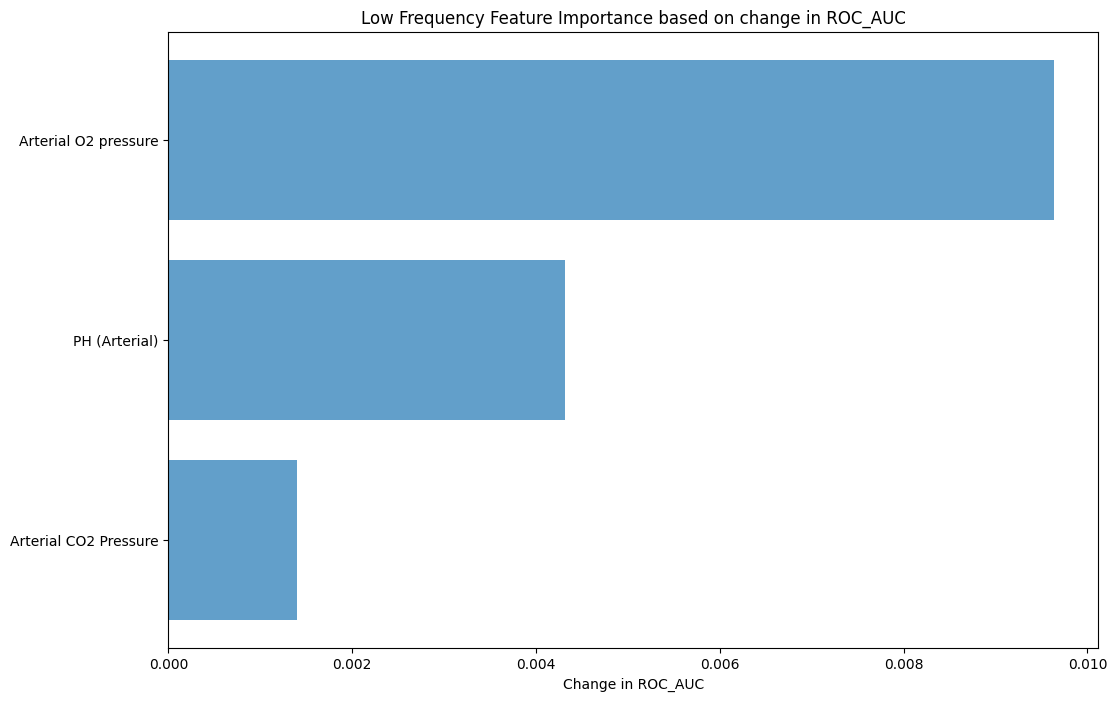

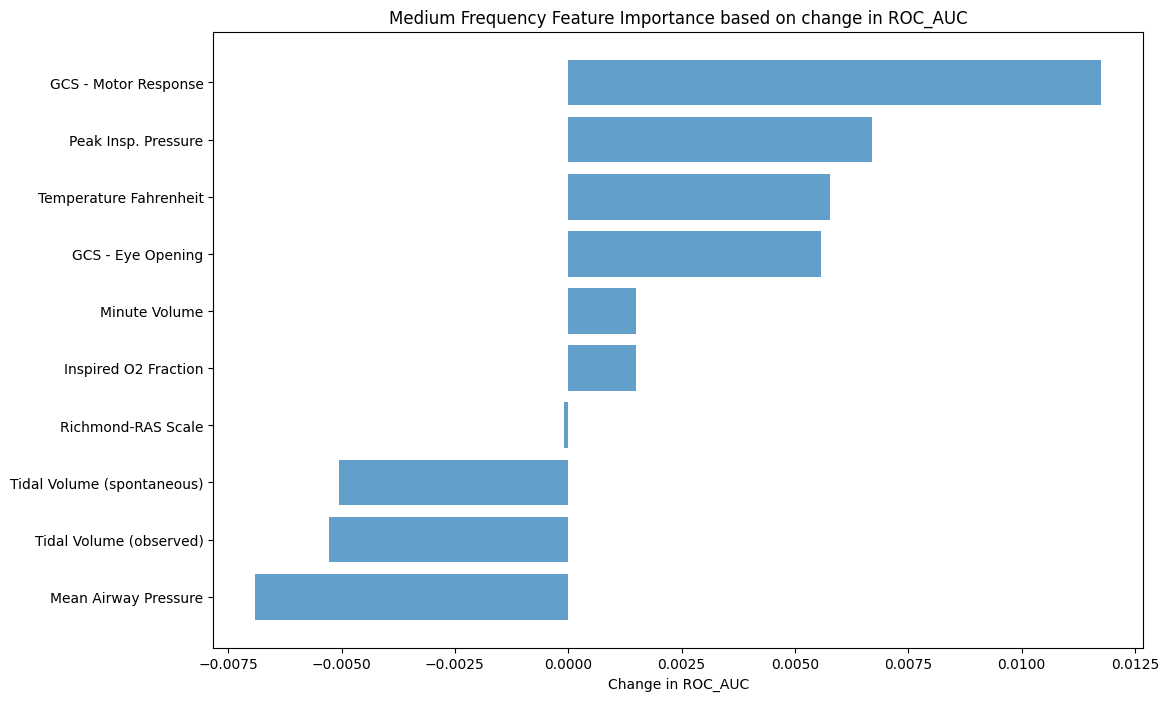

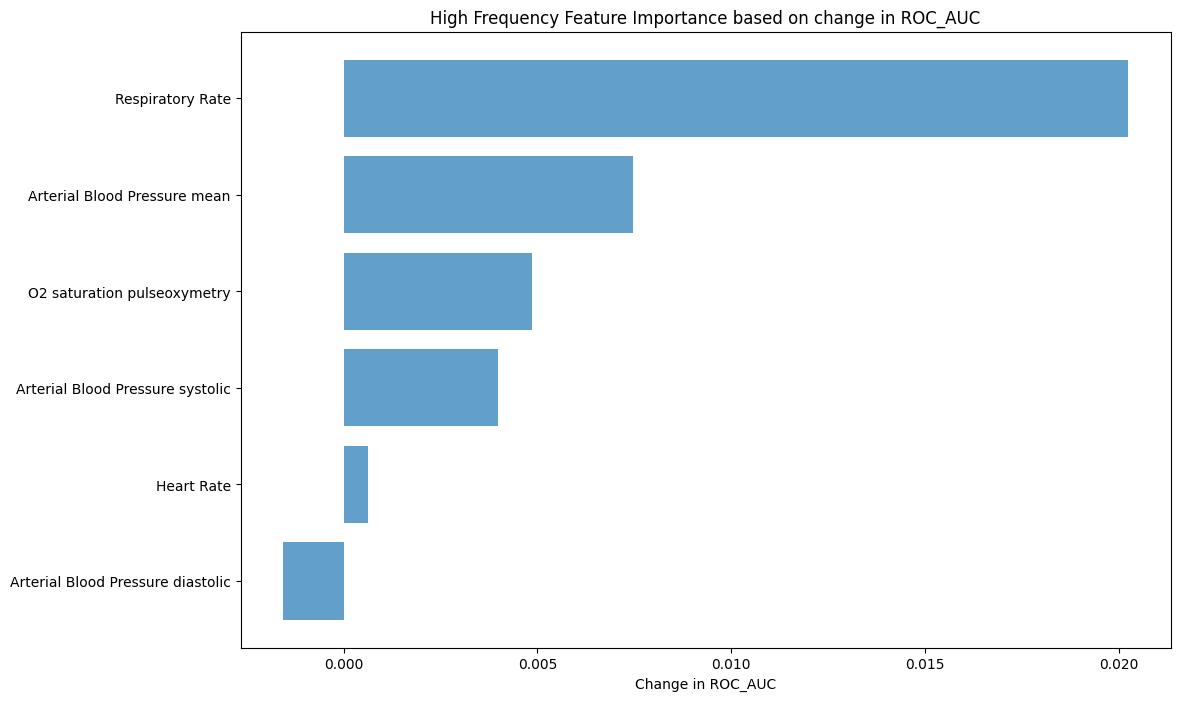

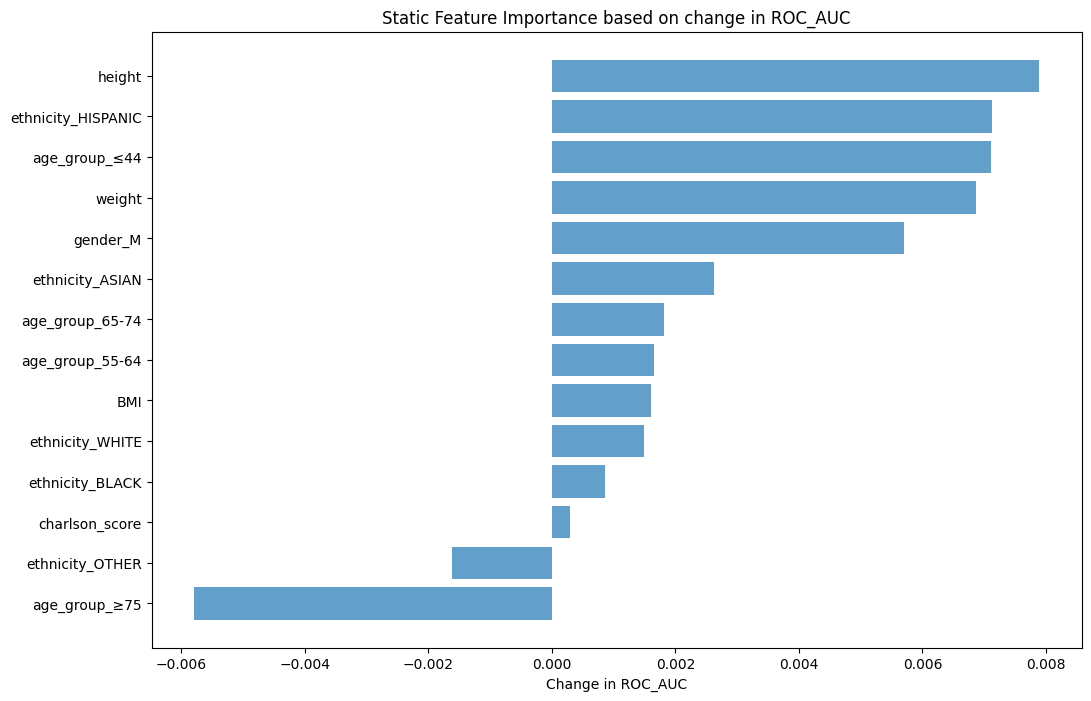

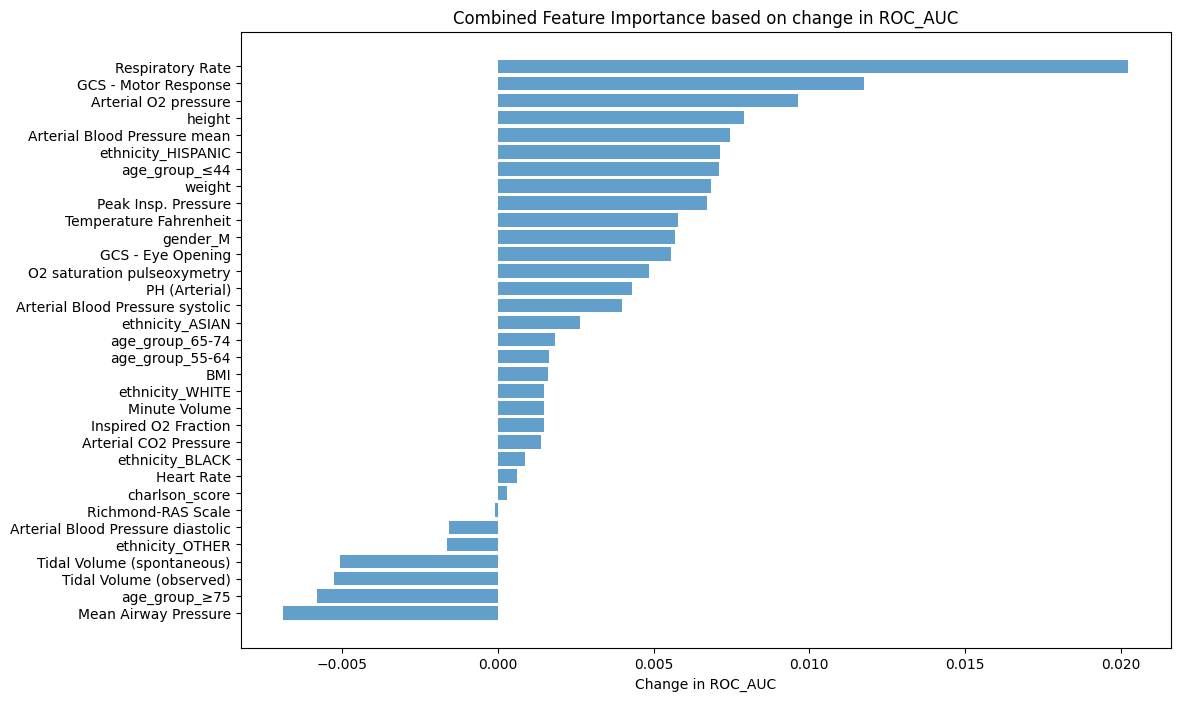

In [ ]:
# Run feature ablation
feature_importances = feature_ablation_with_names(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static,
                                                  labels_train, low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, test_static, labels_test,
                                                  final_model, best_params, device, low_freq_feature_names, medium_freq_feature_names, high_freq_feature_names, static_feature_names)

In [ ]:
feature_importances

accuracy  precision    recall        f1  \
Respiratory Rate                  -0.001063  -0.009751  0.006472  0.005671   
GCS - Motor Response               0.007439   0.012793  0.045307  0.052700   
Arterial O2 pressure               0.002125   0.007016  0.006472  0.007967   
height                             0.004251  -0.080290  0.100324  0.118223   
Arterial Blood Pressure mean       0.003188   0.004850  0.019417  0.021929   
ethnicity_HISPANIC                 0.004251  -0.002284  0.038835  0.043432   
age_group_≤44                     -0.002125  -0.015549  0.006472  0.004899   
weight                             0.018066   0.019710  0.139159  0.179705   
Peak Insp. Pressure                0.002125  -0.007937  0.029126  0.031448   
Temperature Fahrenheit            -0.001063  -0.092506  0.077670  0.085727   
gender_M                          -0.001063  -0.033825  0.035599  0.036287   
GCS - Eye Opening                  0.002125  -0.024675  0.048544  0.052903   
O2 saturation pulseoxymetry        0.004251  -0.019010  0.058252  0.065476   
PH (Arterial)                      0.000000  -0.043702  0.051780  0.055219   
Arterial Blood Pressure systolic  -0.002125  -0.028556  0.022654  0.021595   
ethnicity_ASIAN                    0.002125  -0.003242  0.022654  0.024575   
age_group_65-74                    0.006376  -0.023183  0.077670  0.090172   
age_group_55-64                    0.003188   0.040999 -0.067961 -0.058425   
BMI                                0.001063  -0.056047  0.067961  0.075046   
ethnicity_WHITE                    0.000000   0.012194 -0.022654 -0.021610   
Minute Volume                      0.003188  -0.030406  0.061489  0.068616   
Inspired O2 Fraction               0.004251  -0.025744  0.064725  0.073128   
Arterial CO2 Pressure             -0.001063  -0.080557  0.071197  0.077677   
ethnicity_BLACK                    0.001063  -0.025744  0.042071  0.044898   
Heart Rate                         0.005313   0.014466  0.022654  0.026772   
charlson_score                     0.003188  -0.003964  0.032362  0.035656   
Richmond-RAS Scale                -0.001063  -0.033825  0.035599  0.036287   
Arterial Blood Pressure diastolic  0.001063  -0.028915  0.045307  0.048533   
ethnicity_OTHER                    0.010627  -0.036439  0.116505  0.143681   
Tidal Volume (spontaneous)         0.000000  -0.070540  0.071197  0.078337   
Tidal Volume (observed)            0.004251  -0.019010  0.058252  0.065476   
age_group_≥75                     -0.003188   0.024200 -0.084142 -0.076383   
Mean Airway Pressure               0.003188   0.008768  0.012945  0.015264   

                                    roc_auc  specificity  
Respiratory Rate                   0.020242    -0.006472  
GCS - Motor Response               0.011752    -0.045307  
Arterial O2 pressure               0.009637    -0.006472  
height                             0.007891    -0.100324  
Arterial Blood Pressure mean       0.007456    -0.019417  
ethnicity_HISPANIC                 0.007123    -0.038835  
age_group_≤44                      0.007110    -0.006472  
weight                             0.006862    -0.139159  
Peak Insp. Pressure                0.006703    -0.029126  
Temperature Fahrenheit             0.005781    -0.077670  
gender_M                           0.005699    -0.035599  
GCS - Eye Opening                  0.005566    -0.048544  
O2 saturation pulseoxymetry        0.004859    -0.058252  
PH (Arterial)                      0.004312    -0.051780  
Arterial Blood Pressure systolic   0.003979    -0.022654  
ethnicity_ASIAN                    0.002632    -0.022654  
age_group_65-74                    0.001823    -0.077670  
age_group_55-64                    0.001654     0.067961  
BMI                                0.001613    -0.067961  
ethnicity_WHITE                    0.001495     0.022654  
Minute Volume                      0.001490    -0.061489  
Inspired O2 Fraction               0.001485    -0.064725  
Arterial CO2 Pressure    

In [ ]:
feature_importances['feature'] = feature_importances.index

In [ ]:
# Combine all dynamic feature names
all_dynamic_feature_names = np.concatenate((low_freq_feature_names, medium_freq_feature_names, high_freq_feature_names))
all_dynamic_feature_names = all_dynamic_feature_names.tolist()
feature_importances['feature'] = feature_importances.index

In [ ]:
def plot_feature_importances(dynamic_feature_names, static_feature_names, ablation_df):
    """
    Plots the feature importances for dynamic and static features based on ROC AUC change.

    Parameters:
    dynamic_feature_names (list): List of dynamic feature names.
    static_feature_names (list): List of static feature names.
    ablation_df (pd.DataFrame): DataFrame containing the feature importances with a 'feature' column and a 'roc_auc' column.
    """
    # Filter dynamic and static features
    dynamic_features_df = ablation_df[ablation_df['feature'].isin(dynamic_feature_names)]
    static_features_df = ablation_df[ablation_df['feature'].isin(static_feature_names)]

    # Plot dynamic features
    plt.figure(figsize=(12, 8))
    plt.barh(dynamic_features_df['feature'], dynamic_features_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Dynamic Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot static features
    plt.figure(figsize=(12, 8))
    plt.barh(static_features_df['feature'], static_features_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Static Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

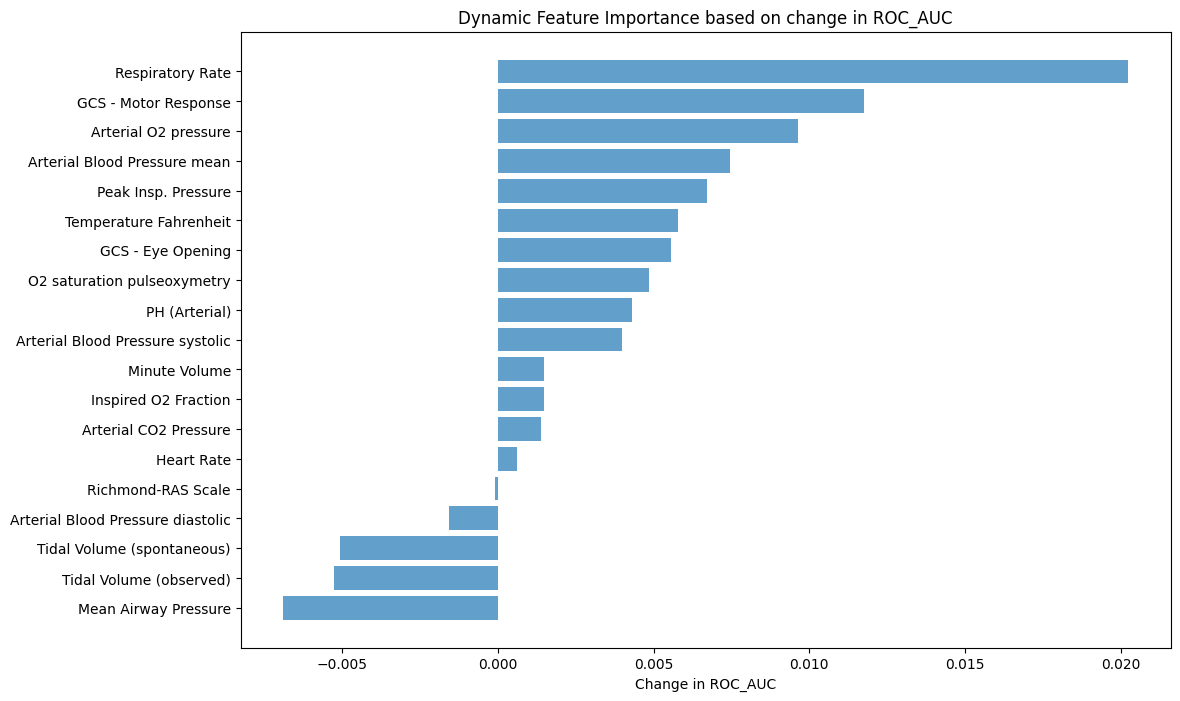

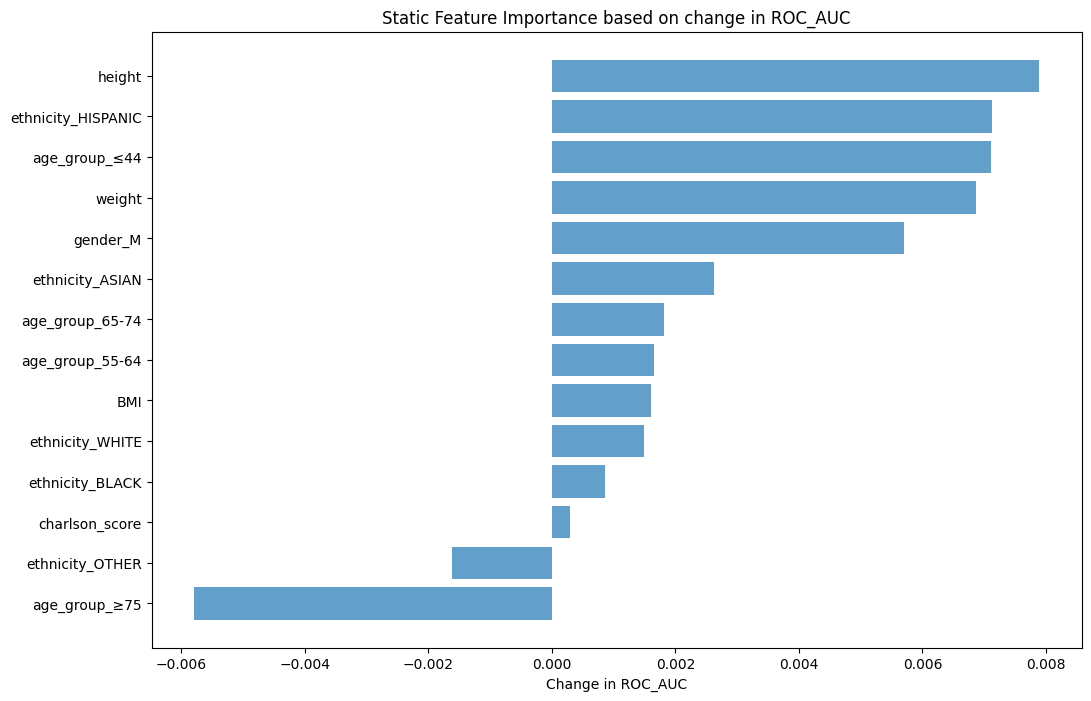

In [ ]:
plot_feature_importances(all_dynamic_feature_names, static_feature_names, feature_importances)